# Objectives


* To introduce you to PyTorch (https://pytorch.org/docs/stable/index.html), which is one of the most widely used software libraries for neural networks.
>**Remember**: It is your responsibility as a machine learning scientist to read documentations for any library function you use and to thoroughly understand what it is doing, if it validly serves your purpose, and which of its parameters you need to consider.

* To apply the perceptron and multilayer perceptron from Week 4 lecture to automatic detection of the number of days of ground frost and snow based on other weather variables.

# Section 1 - Load the UK Met (60km, 2010-2022) data

Same as for the Week 3 lab,

1. You need to first download the data before you can get started. Download from the Week 3 page for the module, on Canvas (see 'Week 3 Lab Dataset' on the page). The file you download will be named *curated_data_1month_2010-2022_nonans.csv*.

2. Then, use the file menu in Google Colab to upload the file to your Colab directory. Once upload is complete, you should be able to see the file on the listed contents of your Colab directory.

3. You can now run the code in the cell below to load the data.

In [2]:
import csv
import numpy


#!ls  /content

data_file_full_path = "/Users/suli/Documents/source/repo/MachineLearning/Week 4/curated_data_1month_2010-2022_nonans.csv"

data_as_list = []

# load the dataset
with open(data_file_full_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    row_count = 0
    for row in csv_reader:

      if row_count > 0:
        data_as_list.append([float(val) for val in row])
      row_count += 1
data = numpy.array(data_as_list)

# check its shape
print("\n The dataset has shape: "+str(data.shape))


# get features and labels from the data
# based on the objectives (see the Objectives section)
feat_col = [5, 6, 7, 8, 9, 10, 11]
ground_frost_col = 4
snow_col = 12

feats = data[:, feat_col]
ground_frost_label = data[:, ground_frost_col]
snow_label = data[:, snow_col]


# take a peek
print("\n A peek at the dataset features: \n"+str(feats))
print("\n A peek at the ground frost labels: \n"+str(ground_frost_label))
print("\n A peek at the snow labels: \n"+str(snow_label))



 The dataset has shape: (10296, 13)

 A peek at the dataset features: 
[[8.93698275e+01 1.02266536e+03 6.45115642e+01 ... 6.45810733e+00
  6.72744772e+00 1.12235238e+02]
 [8.94462109e+01 1.02270800e+03 5.74868117e+01 ... 5.88191052e+00
  6.23064828e+00 1.16354749e+02]
 [8.93435447e+01 1.02243684e+03 6.82935149e+01 ... 4.62830127e+00
  6.29080656e+00 5.75377881e+01]
 ...
 [8.78370293e+01 1.00645706e+03 1.38800195e+01 ... 4.96064026e+00
  1.85626301e+00 1.77242463e+02]
 [8.88116315e+01 1.00662248e+03 2.05853162e+01 ... 4.93635497e+00
  7.75835354e-01 1.35402879e+02]
 [8.27601516e+01 1.00593830e+03 1.05309193e+01 ... 8.38081942e+00
  3.54509758e+00 1.40831213e+02]]

 A peek at the ground frost labels: 
[ 9.84928987 10.85267889 12.97189949 ... 21.7275541  23.77582838
 17.35386163]

 A peek at the snow labels: 
[0.69719979 1.62952568 1.17293773 ... 7.99709543 8.468159   6.3599061 ]


# Section 2 - Split into training, validation, and test sets

In [6]:
from sklearn.model_selection import train_test_split

all_ids = numpy.arange(0, feats.shape[0])

random_seed = 1

# First randomly split the data into 70:30 to get the training set
train_set_ids, rem_set_ids = train_test_split(all_ids, test_size=0.3, train_size=0.7,
                                 random_state=random_seed, shuffle=True)


# Then further split the remaining data 50:50 into validation and test sets
val_set_ids, test_set_ids = train_test_split(rem_set_ids, test_size=0.5, train_size=0.5,
                                 random_state=random_seed, shuffle=True)


train_data = feats[train_set_ids, :]
train_ground_frost_labels = ground_frost_label[train_set_ids]
train_snow_labels = snow_label[train_set_ids]

val_data = feats[val_set_ids, :]
val_ground_frost_labels = ground_frost_label[val_set_ids]
val_snow_labels = snow_label[val_set_ids]

test_data = feats[test_set_ids, :]
test_ground_frost_labels = ground_frost_label[test_set_ids]
test_snow_labels = snow_label[test_set_ids]

# Section 3 - Scale (i.e. normalize) the input data

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feats)
scaled_feats = scaler.transform(feats)
print("\n A peek at the scaled dataset features: \n"+str(scaled_feats))


scaled_train_data = scaled_feats[train_set_ids, :]
scaled_val_data = scaled_feats[val_set_ids, :]
scaled_test_data = scaled_feats[test_set_ids, :]


 A peek at the scaled dataset features: 
[[ 1.32716655  1.57084147 -0.88330353 ...  1.51819974 -0.59716362
   0.21295927]
 [ 1.34196535  1.57808582 -0.99442844 ...  1.03005351 -0.70725389
   0.27324641]
 [ 1.32207443  1.53201409 -0.82347666 ... -0.03198748 -0.69392287
  -0.58751254]
 ...
 [ 1.03019683 -1.18300764 -1.68424647 ...  0.24956567 -1.67661336
   1.16430985]
 [ 1.2190197  -1.15490117 -1.57817505 ...  0.2289915  -1.91603506
   0.55200694]
 [ 0.04658465 -1.27114612 -1.73722605 ...  3.1470957  -1.30236928
   0.6314481 ]]


# Section 4 - Train and evaluate a perceptron model


* Implement a perceptron from scratch. (See Week 4 lecture for the formal definition, i.e. mathematics, of a perceptron.)
* Train and evaluate the perceptron for classification of ground frost label into 2 classes. (See Week 3 lab for preparation of the dataset for classification)

**Solution**

In [8]:
### Implement a perceptron from scratch

# y_cap = sign(xw)
def predict(x, w):

  # Compute the product xw
  y_cap = numpy.matmul(x, w)

  # Compute the activation sign(xw)
  numpy.place(y_cap, y_cap<0, -1)
  numpy.place(y_cap, y_cap>=0, 1)

  return y_cap


# Loss = 0 if y and y_cap are same sign
# Loss = -sum_over_n{y(n)x(n)w}
def compute_loss(y, y_cap, x, w):

  # Set loss to zero as default
  loss = numpy.zeros((y.shape[0],))

  for n in numpy.arange(y.shape[0]):
    # For each n, check if y(n) and y_cap(n) are not the same sign
    # and compute y(n)x(n)w if true
    if y[n, 0]*y_cap[n, 0] < 0:
      loss_n = -numpy.reshape(y[n, 0], (1, 1))*numpy.matmul(x[n, :], w)
      loss[n] = loss_n[0, 0]


  return numpy.mean(loss)


# w(t+1) = w(t) + lr*dL/dw
# dl/dw = -sum_over_n{y(n)x(n)I(y/y_cap)}
# where I(y/y_cap) = 1 if y and y_cap are not the same sign
# and 0 otherwise
def update_weights(old_w, lr, x, y, y_cap):

  mul = numpy.zeros((y.shape[0], 1))

  for i in numpy.arange(y.shape[0]):
    if y[i, 0]*y_cap[i, 0] < 0: mul[i, 0] = 1


  loss_grad = -numpy.sum(numpy.matmul(numpy.transpose(y*mul), x), axis=0, keepdims=True)

  new_w = old_w - lr*numpy.transpose(loss_grad)

  return new_w



In [9]:

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy


### Recode the ground frost labels into -1 and 1


# to obtain an even distribution of data instances across classes
# split based on distribution of given data (use the quartile information)
# and take into consideration that the max possible number of days of ground frost
# is 31 days since the longest month in the year has that number of days

ground_frost_label_class = deepcopy(ground_frost_label)
numpy.place(ground_frost_label_class, ground_frost_label_class<=6.87, -1)
numpy.place(ground_frost_label_class, ground_frost_label_class>6.87, 1)

print("\n A peek at the two-class ground frost labels: \n"+str(ground_frost_label_class))


train_ground_frost_labels_class = ground_frost_label_class[train_set_ids]
val_ground_frost_labels_class = ground_frost_label_class[val_set_ids]
test_ground_frost_labels_class = ground_frost_label_class[test_set_ids]


 A peek at the two-class ground frost labels: 
[1. 1. 1. ... 1. 1. 1.]


Epoch 0 : perceptron loss - 0.5210, perceptron accuracy - 0.4078
Epoch 1 : perceptron loss - 0.2727, perceptron accuracy - 0.6008
Epoch 2 : perceptron loss - 0.1642, perceptron accuracy - 0.7067
Epoch 3 : perceptron loss - 0.1092, perceptron accuracy - 0.7737
Epoch 4 : perceptron loss - 0.0780, perceptron accuracy - 0.8134
Epoch 5 : perceptron loss - 0.0574, perceptron accuracy - 0.8375
Epoch 6 : perceptron loss - 0.0435, perceptron accuracy - 0.8625
Epoch 7 : perceptron loss - 0.0338, perceptron accuracy - 0.8778
Epoch 8 : perceptron loss - 0.0267, perceptron accuracy - 0.8923
Epoch 9 : perceptron loss - 0.0219, perceptron accuracy - 0.9054
Epoch 10 : perceptron loss - 0.0183, perceptron accuracy - 0.9123
Epoch 11 : perceptron loss - 0.0154, perceptron accuracy - 0.9179
Epoch 12 : perceptron loss - 0.0132, perceptron accuracy - 0.9220
Epoch 13 : perceptron loss - 0.0113, perceptron accuracy - 0.9234
Epoch 14 : perceptron loss - 0.0099, perceptron accuracy - 0.9274
Epoch 15 : perceptro

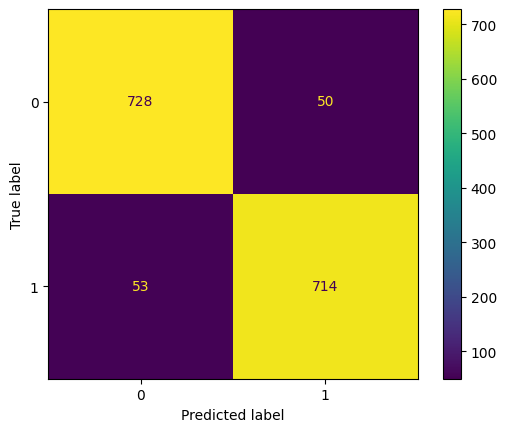

In [10]:
import matplotlib.pyplot as plt

### Train and evaluate the perceptron model

# Initialize parameters (i.e. weights and bias) and hyperparameters
lr = 0.0001
random_seed = 1
rng =  numpy.random.default_rng(random_seed)
w_perc = rng.random((scaled_train_data.shape[1]+1, 1)) #includes the bias
max_epochs = 30
num_iters = scaled_train_data.shape[0]

x_perc = numpy.concatenate([scaled_train_data, numpy.ones((scaled_train_data.shape[0], 1))], axis=1) #bias column added
y_perc = deepcopy(numpy.reshape(train_ground_frost_labels_class, (-1, 1)))



# Train the model - optimizing the weights via stochastic gradient descent
for e in numpy.arange(max_epochs):

  for i in numpy.arange(num_iters):

    x_i = numpy.reshape(x_perc[i, :], (1, -1))
    y_i =  numpy.reshape(y_perc[i], (1, 1))

    w_perc = update_weights(w_perc, lr, x_i, y_i, predict(x_i, w_perc))

  train_loss_perc = compute_loss(y_perc, predict(x_perc, w_perc), x_perc, w_perc)
  train_acc_perc = accuracy_score(y_perc, predict(x_perc, w_perc))
  print("Epoch {} : perceptron loss - {:.4f}, perceptron accuracy - {:.4f}".format(e, train_loss_perc, train_acc_perc))


# Evaluate the trained model
x_test_perc = numpy.concatenate([scaled_test_data, numpy.ones((scaled_test_data.shape[0], 1))], axis=1) #bias column added
y_test_perc = deepcopy(numpy.reshape(test_ground_frost_labels_class, (-1, 1)))
y_cap_test_perc = predict(x_test_perc, w_perc)
test_acc_perc = accuracy_score(y_test_perc, y_cap_test_perc)
print("\n Test accuracy - {:.4f}".format(test_acc_perc))
test_f1_scores_perc = f1_score(y_test_perc, y_cap_test_perc, average=None)
print("\n F1 scores:", test_f1_scores_perc)
print("\n Confusion matrix:")
confus_mat = confusion_matrix(y_test_perc, y_cap_test_perc)
disp = ConfusionMatrixDisplay(confus_mat)
disp.plot()
plt.show()



# Section 5 - Train and evaluate a multilayer perceptron (MLP)

In [11]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


### Create the methods to be used

# Create the neural network structure
# for a 3-layer MLP
class three_layer_MLP(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_layer_sizes,
                 output_size):
        super().__init__()
        self.hidden_l1 = nn.Linear(input_size, hidden_layer_sizes[0])
        self.hidden_l2 = nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])
        self.output_l3 = nn.Linear(hidden_layer_sizes[1], output_size)


    def forward(self, inputs):
        out = self.hidden_l1(inputs)
        out = self.hidden_l2(out)
        out = self.output_l3(out)
        out = torch.softmax(out, 1)
        return out


# A method for computing performance metrics of interest
def my_metrics(labels, predictions, show_confusion_matrix=False):

    ## First work out which class has been predicted for each data sample.
    ## Finally return the classification performance
    predictions_numpy = predictions.detach().numpy()
    predicted_classes = numpy.argmax(predictions_numpy, axis=1)
    f1_scores = f1_score(labels, predicted_classes, average=None)
    acc = accuracy_score(labels, predicted_classes)

    if show_confusion_matrix:
      print("\n Confusion matrix:")
      confus_mat = confusion_matrix(labels, predicted_classes)
      disp = ConfusionMatrixDisplay(confus_mat)
      disp.plot()
      plt.show()

    return f1_scores, acc


# A class for managing the data for training the model
class MetDataset(Dataset):
    def __init__(self, feats, labels):
        # Convert features from numpy arrays to PyTorch tensors
        self.feats = torch.tensor(feats, dtype=torch.float32)

        # Recode class label -1 to 0
        # as the PyTorch library requires class labels to be numbered from zero
        numpy.place(labels, labels==-1, 0)

        # Convert labels from numpy arrays to PyTorch tensors
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        return self.feats[idx, :], self.labels[idx]


epoch: 0 - train loss: 0.6956 train acc: 0.5714
epoch: 1 - train loss: 0.6883 train acc: 0.5714
epoch: 2 - train loss: 0.6815 train acc: 0.5714
epoch: 3 - train loss: 0.6749 train acc: 0.7143
epoch: 4 - train loss: 0.6683 train acc: 0.8571
epoch: 5 - train loss: 0.6618 train acc: 0.7143
epoch: 6 - train loss: 0.6550 train acc: 0.7143
epoch: 7 - train loss: 0.6480 train acc: 0.7143
epoch: 8 - train loss: 0.6408 train acc: 0.7143
epoch: 9 - train loss: 0.6332 train acc: 0.7143
epoch: 10 - train loss: 0.6255 train acc: 0.7143
epoch: 11 - train loss: 0.6175 train acc: 0.7143
epoch: 12 - train loss: 0.6095 train acc: 0.7143
epoch: 13 - train loss: 0.6015 train acc: 0.7143
epoch: 14 - train loss: 0.5937 train acc: 0.7143
epoch: 15 - train loss: 0.5862 train acc: 0.7143
epoch: 16 - train loss: 0.5791 train acc: 0.7143
epoch: 17 - train loss: 0.5724 train acc: 0.7143
epoch: 18 - train loss: 0.5663 train acc: 0.7143
epoch: 19 - train loss: 0.5608 train acc: 0.7143
epoch: 20 - train loss: 0.5558

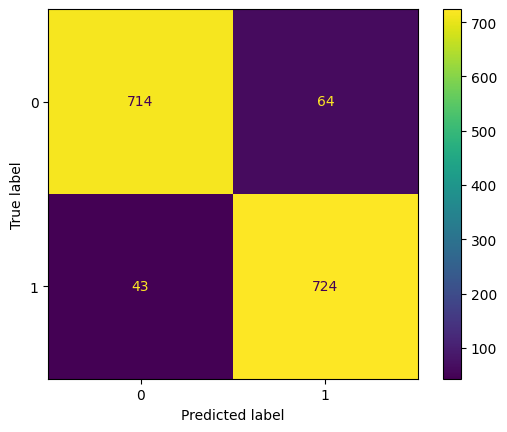


 test accuracy: 0.93

 The F1 scores for each of the classes are: [0.93029316 0.93118971]

 Training loss:


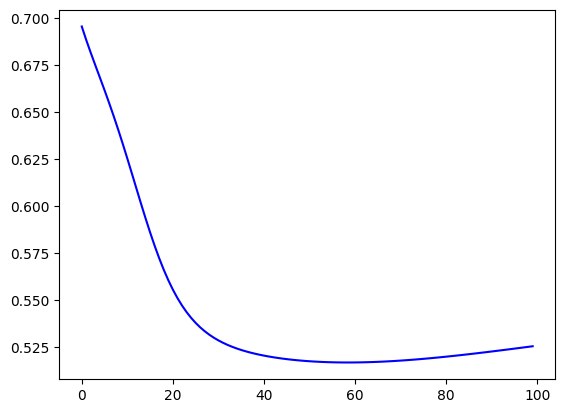

In [13]:
import random


### Train and evaluate the 3-layer MLP

# Ensure reproducibility
# for PyTorch operations that use random numbers internally
random.seed(random_seed)
torch.manual_seed(random_seed)
numpy.random.seed(random_seed)

# Create an instance of the 3-layer MLP
feature_count = train_data.shape[1]
hidden_layer_sizes = [10, 10]
class_count = numpy.unique(ground_frost_label_class).shape[0]
MLP_model = three_layer_MLP(feature_count, hidden_layer_sizes, class_count)


# Set values for hyperparameters
num_epochs = 100
learning_rate = 0.001
batch_size = 50


# Set up the data loading by batch
# With the test and validation sets having only one batch
train_set = MetDataset(scaled_train_data, train_ground_frost_labels_class)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

val_set = MetDataset(scaled_val_data, val_ground_frost_labels_class)
val_dataloader = DataLoader(val_set, batch_size=len(val_set))

test_set = MetDataset(scaled_test_data, test_ground_frost_labels_class)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))



# Set up the SGD optimizer for updating the model weights
optimizer = optim.SGD(MLP_model.parameters(), lr=learning_rate)


# Compute cross entropy loss against the training labels
loss_function = nn.CrossEntropyLoss()



best_model_acc = 0
losses = []

# Iterate over the dataset at two different stages:
# 1. Iterate over the batches in the dataset (inner for loop below)
# One complete set of iteration through the dataset (i.e. having gone over
# all batches in the dataset at least once) = One epoch
# 2. Iterate over the specified numeber of epochs (outer for loop below)
for epoch in range(0, num_epochs):

    # Set the model to training mode
    MLP_model.train()


    for batch, (X_train, y_train) in enumerate(train_dataloader):

      # Zero out the `.grad` buffers,
      # otherwise on the backward pass we'll add the
      # new gradients to the old ones.
      optimizer.zero_grad()

      # Compute the forward pass and then the loss
      train_pred = MLP_model.forward(X_train)
      train_loss = loss_function(train_pred, y_train)
      train_avg_f1_score, train_acc = my_metrics(y_train, train_pred)

      # Compute the model parameters' gradients
      # and propagating the loss backwards through the network.
      train_loss.backward()

      # Update the model parameters using those gradients
      optimizer.step()

    # How well the network does on the batches
    # is an indication of how well training is progressing
    print("epoch: {} - train loss: {:.4f} train acc: {:.4f}".format(
        epoch,
        train_loss.item(),
        train_acc))

    losses.append(train_loss.item())


# Finally, test your model on the test set and get an estimate of its performance.
# First, set the model to evaluation mode
MLP_model.eval()
for batch, (X_test, y_test) in enumerate(test_dataloader):
  test_pred = MLP_model.forward(X_test)
  test_f1_scores, test_accuracy = my_metrics(y_test, test_pred, show_confusion_matrix=True)
  print("\n test accuracy: {:2.2f}".format(test_accuracy))
  test_pred_numpy = test_pred.detach().numpy()
  print('\n The F1 scores for each of the classes are: '+str(test_f1_scores))

  print("\n Training loss:")
  fig, ax = plt.subplots()
  losses = numpy.array(losses)
  ax.plot(losses, 'b-', label='training loss')


# Section 6 - Train the MLP with early stopping

* Edit the code in Section 5 to include early stopping. (See Week 4 lecture for information on early stopping.)

**Solution**

Found improvement in performance. New model saved.
epoch: 0 - train loss: 0.6956 train acc: 0.5714 val loss: 0.7133 val acc: 0.4404
Found improvement in performance. New model saved.
epoch: 1 - train loss: 0.6883 train acc: 0.5714 val loss: 0.7015 val acc: 0.4747
Found improvement in performance. New model saved.
epoch: 2 - train loss: 0.6815 train acc: 0.5714 val loss: 0.6904 val acc: 0.4974
Found improvement in performance. New model saved.
epoch: 3 - train loss: 0.6749 train acc: 0.7143 val loss: 0.6798 val acc: 0.5745
Found improvement in performance. New model saved.
epoch: 4 - train loss: 0.6683 train acc: 0.8571 val loss: 0.6695 val acc: 0.7066
Found improvement in performance. New model saved.
epoch: 5 - train loss: 0.6618 train acc: 0.7143 val loss: 0.6593 val acc: 0.7869
Found improvement in performance. New model saved.
epoch: 6 - train loss: 0.6550 train acc: 0.7143 val loss: 0.6490 val acc: 0.8251
Found improvement in performance. New model saved.
epoch: 7 - train loss: 0.

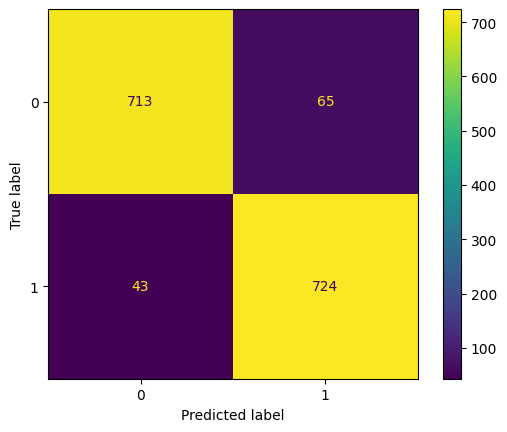


 test accuracy: 0.93

 The F1 scores for each of the classes are: [0.92959583 0.93059126]

 Loss graph:


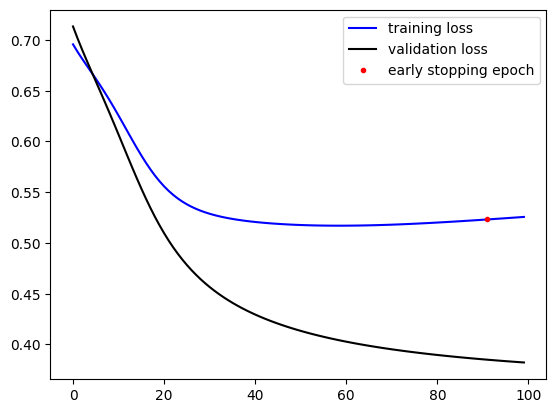

In [14]:

### Train and evaluate the 3-layer MLP with early stopping

# Ensure comparability with Section 5 (and reproducibility)
# for PyTorch operations that use random numbers internally
random.seed(random_seed)
torch.manual_seed(random_seed)
numpy.random.seed(random_seed)

# Create a fresh instance of the 3-layer MLP
feature_count = train_data.shape[1]
hidden_layer_sizes = [10, 10]
class_count = numpy.unique(ground_frost_label_class).shape[0]
MLP_model = three_layer_MLP(feature_count, hidden_layer_sizes, class_count)


# Set values for hyperparameters
num_epochs = 100
learning_rate = 0.001
batch_size = 50



# Set up the SGD optimizer for updating the model weights
optimizer = optim.SGD(MLP_model.parameters(), lr=learning_rate)


# Compute cross entropy loss against the training labels
loss_function = nn.CrossEntropyLoss()



best_model_acc = 0
losses = []

# Iterate over the dataset at two different stages:
# 1. Iterate over the batches in the dataset (inner for loop below)
# One complete set of iteration through the dataset (i.e. having gone over
# all batches in the dataset at least once) = One epoch
# 2. Iterate over the specified numeber of epochs (outer for loop below)
for epoch in range(0, num_epochs):

    # Set the model to training mode
    MLP_model.train()

    # Initialize for early stopping
    if epoch == 0:
      best_model = deepcopy(MLP_model)
      best_epoch = 0

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      # Zero out the `.grad` buffers,
      # otherwise on the backward pass we'll add the
      # new gradients to the old ones.
      optimizer.zero_grad()

      # Compute the forward pass and then the loss
      train_pred = MLP_model.forward(X_train)
      train_loss = loss_function(train_pred, y_train)
      train_avg_f1_score, train_acc = my_metrics(y_train, train_pred)

      # Compute the model parameters' gradients
      # and propagating the loss backwards through the network.
      train_loss.backward()

      # Update the model parameters using those gradients
      optimizer.step()

    # Evaluate on the validation set
    # for early stopping
    MLP_model.eval()
    for batch, (X_val, y_val) in enumerate(val_dataloader):
      val_pred = MLP_model.forward(X_val)
      val_loss = loss_function(val_pred, y_val)
      val_avg_f1_score, val_acc = my_metrics(y_val, val_pred)

    if val_acc > best_model_acc:
      best_epoch = epoch
      best_model_acc = val_acc
      best_model = deepcopy(MLP_model)
      print('Found improvement in performance. New model saved.')

    # How well the network does on the batches
    # is an indication of how well training is progressing
    print("epoch: {} - train loss: {:.4f} train acc: {:.4f} val loss: {:.4f} val acc: {:.4f}".format(
        epoch,
        train_loss.item(),
        train_acc,
        val_loss.item(),
        val_acc))

    losses.append([train_loss.item(), val_loss.item()])

MLP_model_early_stopping = best_model

# Finally, test your model on the test set and get an estimate of its performance.
# First, set the model to evaluation mode
MLP_model_early_stopping.eval()
for batch, (X_test, y_test) in enumerate(test_dataloader):
  test_pred = MLP_model_early_stopping.forward(X_test)
  test_f1_scores, test_accuracy = my_metrics(y_test, test_pred, show_confusion_matrix=True)
  print("\n test accuracy: {:2.2f}".format(test_accuracy))
  test_pred_numpy = test_pred.detach().numpy()
  print('\n The F1 scores for each of the classes are: '+str(test_f1_scores))

  print("\n Loss graph:")
  fig, ax = plt.subplots()
  losses = numpy.array(losses)
  ax.plot(losses[:, 0], 'b-', label='training loss')
  ax.plot(losses[:, 1], 'k-', label='validation loss')
  ax.plot(best_epoch, losses[best_epoch, 0], 'r.', label='early stopping epoch')
  plt.legend(loc='upper right')


# Section 7 - Explore PyTorch MLP training and evaluation

1. The first part of the code in Section 5 uses *torch.nn.Linear()* in building the 3-layer MLP. What do you think that this bit of code does?

2. Why was *numpy.argmax(predictions_numpy, axis=1)* needed to get predictions from the MLP? (See the *my_metrics(...)* method of the first part of the Section 5 code.)

3. Try different settings for the hyperparameters of the MLP in Section 5, particularly the:
  * output layer activation function
  * loss function
  * number of epochs
  * learning rate
  * batch size
  * optimization algorithm

**Solution**

1. *torch.nn.Linear()* implements a fully-connected layer. For more details, see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear.

2. Recall that the output layer in Section 5 has number of units equal to the number of classes for the classification task of interest. A softmax activation (see Week 4 lecture for the formula) recodes the outputs such that the sum of the outputs equals 1. The recoded can be intrepreted as probability of the corresponding class (see Week 3 lecture), and so, the class corresponding to the highest of the outputs can be taken to be the class predicted by the model. The *argmax* line of code is used to obtain the class with the higher probability.


3. Hyperparameters

  * Softmax was used as the activation function for the output layer in Section 5. The output layer activation was defined in the *out = torch.softmax(out, 1)* line of the *three_layer_MLP(nn.Module)* class in the first part of the Section 5 code. The code below instead uses sigmoid activation.
    * See Week 4 lecture for the formula for the sigmoid activation.
    * See Week 3 lecture for interpretation of sigmoid activation as probability.
    * Note that the use of the sigmoid activation is only valid here because there are just two classes. Think about when the sigmoid activation function could be valid for multiclass classification, i.e. with more than two classes. You can discuss your thoughts with a TA.

  * Cross-entropy was used as loss function in Section 5. The loss function is defined in the *loss_function = nn.CrossEntropyLoss()* line of the second part of the Section 5 code. The code below instead uses mean squared error (MSE).
    * See Week 3 lecture for the formula for cross-entropy.
    * See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss for details about the PyTorch implementation of the cross-entropy loss.
    * See Week 1 lecture for the formula for MSE.
    * See https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss for details about the PyTorch implementation of the MSE loss.

  * The number of epochs was defined in the *num_epochs = 100* line of the second part of the Section 5 code. The code below instead uses 200 epochs.

  * The learning rate was defined in the *learning_rate = 0.001* line of the second part of the Section 5 code. The code below instead uses learning rate of 0.00001.

  * The batch size was defined in the *batch_size = 50* line of the second part of the Section 5 code. The code below instead uses batch size of 20.

  * Stochastic gradient descent (SGD) was used as optimization algorithm in Section 5. The optimization algorithm was specified in the *optimizer = optim.SGD(model.parameters(), lr=learning_rate)* line of the second part of the Section 5 code. The code below instead uses Adam.
    * See Week 4 lecture for how SGD works.
    * See https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD for details about the PyTorch implementation of the SGD.
    * See https://arxiv.org/abs/1412.6980 for details about the Adam optimization algorithm.
    * See https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam for details about the PyTorch implementation of the Adam.

In [15]:

### Create the methods to be used for a MLP with sigmoid activation in its output layer


# Create the neural network structure
# for a 3-layer MLP with sigmoid activation in the output layer
class three_layer_MLP_sigmoid(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_layer_sizes,
                 output_size):
        super().__init__()
        self.hidden_l1 = nn.Linear(input_size, hidden_layer_sizes[0])
        self.hidden_l2 = nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])
        self.output_l3 = nn.Linear(hidden_layer_sizes[1], output_size)


    def forward(self, inputs):
        out = self.hidden_l1(inputs)
        out = self.hidden_l2(out)
        out = self.output_l3(out)
        out = torch.sigmoid(out)
        return out


# A method for computing performance metrics of interest
def my_metrics_sigmoid(labels, predictions, show_confusion_matrix=False):

    ## First work out which class has been predicted for each data sample.
    ## Finally return the classification performance
    predictions_numpy = predictions.detach().numpy()
    predicted_classes = deepcopy(predictions_numpy)
    numpy.place(predicted_classes, predicted_classes>=0.5, 1)
    numpy.place(predicted_classes, predicted_classes<0.5, 0)

    f1_scores = f1_score(labels.flatten(), predicted_classes.flatten(), average=None)
    acc = accuracy_score(labels.flatten(), predicted_classes.flatten())


    if show_confusion_matrix:
      print("\n Confusion matrix:")
      confus_mat = confusion_matrix(labels.flatten(), predicted_classes.flatten())
      disp = ConfusionMatrixDisplay(confus_mat)
      disp.plot()
      plt.show()

    return f1_scores, acc


# A class for managing the data for training the model
class MetDataset_sigmoid(Dataset):
    def __init__(self, feats, labels):
        # Convert features from numpy arrays to PyTorch tensors
        self.feats = torch.tensor(feats, dtype=torch.float32)

        # Recode class label -1 to 0
        # as the PyTorch library requires class labels to be numbered from zero
        numpy.place(labels, labels==-1, 0)

        # Convert labels from numpy arrays to PyTorch tensors
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        return self.feats[idx, :], torch.reshape(self.labels[idx], (1,))


Found improvement in performance. New model saved.
epoch: 0 - train loss: 0.2231 train acc: 0.5714 val loss: 0.2063 val acc: 0.7111
Found improvement in performance. New model saved.
epoch: 1 - train loss: 0.2175 train acc: 0.5714 val loss: 0.2007 val acc: 0.7370
Found improvement in performance. New model saved.
epoch: 2 - train loss: 0.2120 train acc: 0.7143 val loss: 0.1951 val acc: 0.7597
Found improvement in performance. New model saved.
epoch: 3 - train loss: 0.2066 train acc: 0.7143 val loss: 0.1895 val acc: 0.7824
Found improvement in performance. New model saved.
epoch: 4 - train loss: 0.2014 train acc: 0.7143 val loss: 0.1839 val acc: 0.7960
Found improvement in performance. New model saved.
epoch: 5 - train loss: 0.1963 train acc: 0.7143 val loss: 0.1783 val acc: 0.8096
Found improvement in performance. New model saved.
epoch: 6 - train loss: 0.1914 train acc: 0.7143 val loss: 0.1728 val acc: 0.8219
Found improvement in performance. New model saved.
epoch: 7 - train loss: 0.

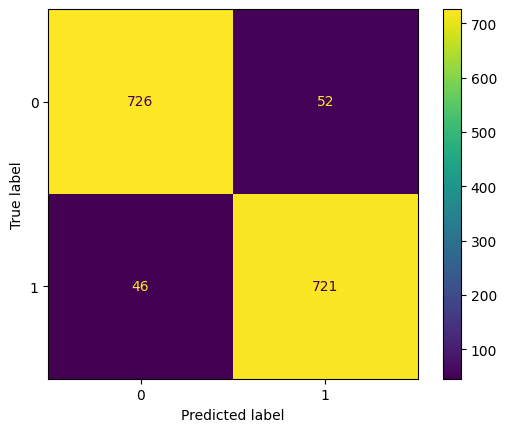


 test accuracy: 0.94

 The F1 scores for each of the classes are: [0.93677419 0.93636364]

 Loss graph:


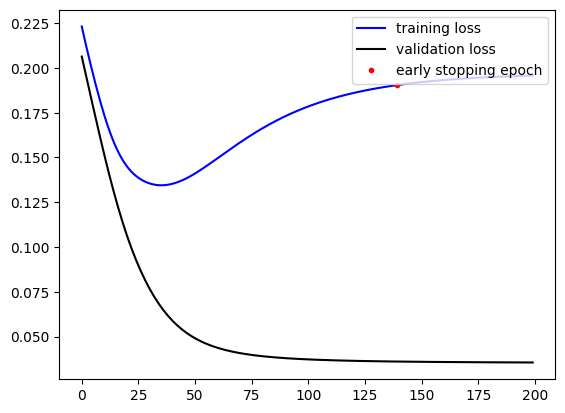

In [16]:

### Train and evaluate the 3-layer MLP with sigmoid activation in the output layer
### with Adam as optimization algorithm, MSE as loss function,
### and 200 epochs, 0.001 as learning rate, and batch size of 20


# Ensure comparability with Section 5 (and reproducibility)
# for PyTorch operations that use random numbers internally
random.seed(random_seed)
torch.manual_seed(random_seed)
numpy.random.seed(random_seed)


# Create an instance of the 3-layer MLP
feature_count = train_data.shape[1]
hidden_layer_sizes = [10, 10]
class_count = numpy.unique(ground_frost_label_class).shape[0]
MLP_model_sigmoid = three_layer_MLP_sigmoid(feature_count, hidden_layer_sizes, 1)


# Set values for hyperparameters
num_epochs = 200
learning_rate = 0.00001
batch_size = 20


# Set up the data loading by batch
# With the test and validation sets having only one batch
train_set = MetDataset_sigmoid(scaled_train_data, train_ground_frost_labels_class)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

val_set = MetDataset_sigmoid(scaled_val_data, val_ground_frost_labels_class)
val_dataloader = DataLoader(val_set, batch_size=len(val_set))

test_set = MetDataset_sigmoid(scaled_test_data, test_ground_frost_labels_class)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))



# Set up the Adam optimizer for updating the model weights
optimizer_Adam = optim.Adam(MLP_model_sigmoid.parameters(), lr=learning_rate)


# Compute MSE loss against the training labels
loss_function_mse = nn.MSELoss()



best_model_acc = 0
losses = []

# Iterate over the dataset at two different stages:
# 1. Iterate over the batches in the dataset (inner for loop below)
# One complete set of iteration through the dataset (i.e. having gone over
# all batches in the dataset at least once) = One epoch
# 2. Iterate over the specified numeber of epochs (outer for loop below)
for epoch in range(0, num_epochs):

    # Set the model to training mode
    MLP_model_sigmoid.train()


    for batch, (X_train, y_train) in enumerate(train_dataloader):

      # Zero out the `.grad` buffers,
      # otherwise on the backward pass we'll add the
      # new gradients to the old ones.
      optimizer_Adam.zero_grad()

      # Compute the forward pass and then the loss
      train_pred = MLP_model_sigmoid.forward(X_train)
      train_loss = loss_function_mse(train_pred, y_train)
      train_avg_f1_score, train_acc = my_metrics_sigmoid(y_train, train_pred)

      # Compute the model parameters' gradients
      # and propagating the loss backwards through the network.
      train_loss.backward()

      # Update the model parameters using those gradients
      optimizer_Adam.step()

    # Evaluate on the validation set
    # for early stopping
    MLP_model_sigmoid.eval()
    for batch, (X_val, y_val) in enumerate(val_dataloader):
      val_pred = MLP_model_sigmoid.forward(X_val)
      val_loss = loss_function_mse(val_pred, y_val)
      val_avg_f1_score, val_acc = my_metrics_sigmoid(y_val, val_pred)

    if val_acc > best_model_acc:
      best_epoch = epoch
      best_model_acc = val_acc
      best_model = deepcopy(MLP_model_sigmoid)
      print('Found improvement in performance. New model saved.')

    # How well the network does on the batches
    # is an indication of how well training is progressing
    print("epoch: {} - train loss: {:.4f} train acc: {:.4f} val loss: {:.4f} val acc: {:.4f}".format(
        epoch,
        train_loss.item(),
        train_acc,
        val_loss.item(),
        val_acc))

    losses.append([train_loss.item(), val_loss.item()])


# Finally, test your model on the test set and get an estimate of its performance.
# First, set the model to evaluation mode
MLP_model_sigmoid.eval()
for batch, (X_test, y_test) in enumerate(test_dataloader):
  test_pred = MLP_model_sigmoid.forward(X_test)
  test_f1_scores, test_accuracy = my_metrics_sigmoid(y_test, test_pred, show_confusion_matrix=True)
  print("\n test accuracy: {:2.2f}".format(test_accuracy))
  test_pred_numpy = test_pred.detach().numpy()
  print('\n The F1 scores for each of the classes are: '+str(test_f1_scores))

  print("\n Loss graph:")
  fig, ax = plt.subplots()
  losses = numpy.array(losses)
  ax.plot(losses[:, 0], 'b-', label='training loss')
  ax.plot(losses[:, 1], 'k-', label='validation loss')
  ax.plot(best_epoch, losses[best_epoch, 0], 'r.', label='early stopping epoch')
  plt.legend(loc='upper right')